In [7]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
sys.path.append("./../utls")
sys.path.append("./..")
import os
from preprocessing import *
from InterfaceDeclaration import LPBFInterface

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,60,     "Base"], # ignored
    [61, 130,  "GP"], # Gas Pore, Unstable keyhole, very hard to predict
    [131, 200, "NP"], # No Pore, Nominal Parameter
    [201, 270, "RLoF"], # Random lack of fusion
    [271, 340, "LoF"] # lack of Fusion, most easy to predict
]

laser_power_setting = [
    [0,60,     "165"], # ignored
    [61, 130,  "110"], # Gas Pore, Unstable keyhole, very hard to predict
    [131, 200, "180"], # No Pore, Nominal Parameter
    [201, 270, "300"], # Random lack of fusion
    [271, 340, "165"] # lack of Fusion, most easy to predict
]

scanning_speed_setting = [
    [0,60,     "900"], # ignored
    [61, 130,  "900"], # Gas Pore, Unstable keyhole, very hard to predict
    [131, 200, "900"], # No Pore, Nominal Parameter
    [201, 270, "900"], # Random lack of fusion
    [271, 340, "900"] # lack of Fusion, most easy to predict
]

In [21]:
class MaPS_LPBF_Construction:
    import os
    from nptdms import TdmsFile
    from natsort import natsorted
    """
    Data reader for the MaPS LPBF EXP1
    
    """
    def __init__(self,daq_dir,lmq_dir,sampling_rate_daq,sampling_rate_lmq,process_regime,laser_power_setting, scanning_speed_setting):
        self.daq_name_list = natsorted(
            [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
        )
        self.lmq_name_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
        self.lmq_channel_name = [
            "Vector ID",
            "meltpooldiode",
            "X Coordinate",
            "Y Coordinate",
            "Laser power",
            "Spare",
            "Laser diode",
            "Varioscan(focal length)",
        ]
        self.daq_dir = daq_dir
        self.lmq_dir = lmq_dir

        self.sampling_rate_lmq = sampling_rate_lmq
        self.sampling_rate_daq = sampling_rate_daq
        self.process_regime = process_regime
        self.laser_power_setting = laser_power_setting
        self.scanning_speed_setting = scanning_speed_setting

        ## Datalist with interface

        # Context info
        self.cube_position = []
        self.laser_power = []
        self.start_coord = []
        self.end_coord = []
        self.scanning_speed = []
        self.regime_info = []

        # defect_labels
        self.defect_labels = []

        # in_process_data
        self.microphone = []
        self.ae = []
        self.photodiode = []


   
    def _read_bin_file(self, file_path:str):
            """Reads a binary file and returns its contents as a bytes object.

            Args:
                file_path: The path to the binary file.

            Returns:
                The contents of the binary file as a bytes object.
            """
            # dtype = np.float32 
            dtype = "<i4"
            num_channels = 8 #  the number of channels
            samples_per_channel = int(np.fromfile(file_path, dtype=dtype).shape[0] / num_channels) # Calculate the number of samples per channel
            data = np.fromfile(file_path, dtype=dtype).reshape(-1,num_channels) # Load the data into a NumPy array
            return data
  
    def _construct_cube_wise_indices(self):

        pulse_on_thershold = 0.2
        sliced_indices_daq = np.asarray(pulse_signal_slicer_by_interval( self._photodiode, self.sampling_rate_daq, pulse_on_thershold=pulse_on_thershold, index_only=True,binary=False))
        sliced_indices_lmq = np.asarray(pulse_signal_slicer_by_interval( self._laserdiode, self.sampling_rate_lmq, pulse_on_thershold=pulse_on_thershold, index_only=True,binary=False))
        while len(sliced_indices_daq)!=len(sliced_indices_lmq)!=5:
            pulse_on_thershold -= 0.05
            sliced_indices_daq = np.asarray(pulse_signal_slicer_by_interval( self._photodiode, self.sampling_rate_daq, pulse_on_thershold=pulse_on_thershold, index_only=True))
            sliced_indices_lmq = np.asarray(pulse_signal_slicer_by_interval( self._laserdiode, self.sampling_rate_lmq, pulse_on_thershold=pulse_on_thershold, index_only=True))

        sliced_indices_lmq_0 = np.zeros([5,2],dtype=int)
        for i, vid in enumerate(np.unique(self.data_lmq[:,0])[1:-1]):
            sliced_indices_lmq_0[i,0], sliced_indices_lmq_0[i,1] = find_first_and_last_indices(self.data_lmq[:,0], vid)
   
        return sliced_indices_lmq, sliced_indices_daq
    
    def _construct_line_wise_indices(self):
        current_cube_lmq = self.sliced_indices_lmq[self.cube_i]
        current_cube_daq = self.sliced_indices_daq[self.cube_i]
        self.current_cube_lmq = current_cube_lmq
        self.current_cube_daq = current_cube_daq

        self.current_laserdiode = self._laserdiode[current_cube_lmq[0]:current_cube_lmq[1]]
        self.current_laserpower = self._laserpower[current_cube_lmq[0]:current_cube_lmq[1]]
        self.current_x = self._x[current_cube_lmq[0]:current_cube_lmq[1]]
        self.current_y = self._y[current_cube_lmq[0]:current_cube_lmq[1]]

        self.current_photodiode = self._photodiode[current_cube_daq[0]:current_cube_daq[1]]
        self.current_ae         = self._ae[current_cube_daq[0]:self.current_cube_daq[1]]
        self.current_mic        = self._mic[current_cube_daq[0]:self.current_cube_daq[1]]
        # print(f"current mic shape :{self.current_mic.shape}")
        
        pulse_on_thershold = 0.21
        line_indices_lmq = np.asarray(pulse_signal_slicer_by_interval(self.current_laserpower,sampling_rate=self.sampling_rate_lmq,min_interval_time=0.0001, index_only=True,pulse_on_thershold=pulse_on_thershold))
        line_indices_daq = np.asarray(pulse_signal_slicer_by_interval(self.current_photodiode,sampling_rate=self.sampling_rate_daq,min_interval_time=0.0001, index_only=True,pulse_on_thershold=pulse_on_thershold))
        line_indices_lmq.shape,line_indices_daq.shape
        while (len(line_indices_lmq)!=len(line_indices_daq)):
            # print(f"T:{pulse_on_thershold:.3}|lmq:{line_indices_lmq.shape}|daq:{line_indices_daq.shape}")
            line_indices_lmq = np.asarray(pulse_signal_slicer_by_interval(self.current_laserpower,sampling_rate=self.sampling_rate_lmq,min_interval_time=0.0001, index_only=True,pulse_on_thershold=pulse_on_thershold))
            line_indices_daq = np.asarray(pulse_signal_slicer_by_interval(self.current_photodiode,sampling_rate=self.sampling_rate_daq,min_interval_time=0.0001, index_only=True,pulse_on_thershold=pulse_on_thershold))
            if pulse_on_thershold<0.11:
                break
            pulse_on_thershold -= 0.05
        min_len = min(len(line_indices_lmq),len(line_indices_daq))
        if min_len<10:
            print(f"Warning, only {min_len} lines in {self.layer_i} {self.cube_i}")
        # return line_indices_lmq[2:min_len-1], line_indices_daq[2:min_len-1]
        return line_indices_lmq[:min_len-1], line_indices_daq[:min_len-1]

    def _construct_data_labels(self):
        for _lmq,_daq in zip(self.line_indices_lmq,self.line_indices_daq):
            lmq_i0, lmq_it = _lmq
            daq_i0, daq_it = _daq
            # print(f"cube:{self.cube_i}|lmq i{_lmq}|daq i{_daq}")
            
            self.cube_position.append(self.cube_i)
            self.laser_power.append(int(self._find_regime_setting(self.layer_i,self.laser_power_setting)))
            self.start_coord.append((self.current_x[lmq_i0],self.current_y[lmq_i0]))
            self.end_coord.append((self.current_x[lmq_it],self.current_y[lmq_it]))
            self.scanning_speed.append(int(self._find_regime_setting(self.layer_i,self.scanning_speed_setting)))
            self.regime_info.append(self._find_regime_setting(self.layer_i))


            self.microphone.append(self.current_mic[daq_i0:daq_it])
            self.ae.append(self.current_ae[daq_i0:daq_it])
            self.photodiode.append(self.current_photodiode[daq_i0:daq_it])
            self.defect_labels.append(0) # //TODO the defect labels
    
    def _construct_line_wise_labels_ram(self,layer_i=None,cube_i=None):
        """
        Construct line wise labels in RAM
        Return: 
            - Context info
                - Cube position (the n-th cube)
                - Laser power
                - Speed (remain constant in this case)
                - Scanning direction
                - Regime info (4 - class classifications)
                    - Base | Base plate, ignored
                    - GP   | Gas pore, or keyhole 
                    - NP   | No pore
                    - RLoF | Random lack of fusion
                    - LoF  | Lack of fusion

            - Strong labels ( TODO )
                    - GP   | Gas pore, or keyhole 
                    - NP   | No pore
                    - RLoF | Random lack of fusion
                    - LoF  | Lack of fusion
            
            - In-process data
                - microphone
                - AE
                - photodiode
        """
        def _run_layer(layer_i,cube_i):
            self.layer_i = layer_i
            # print(f"layer:{layer_i}")
            daq_file_path =os.path.join(self.daq_dir,self.daq_name_list[layer_i])
            lmq_file_path = os.path.join(self.lmq_dir,self.lmq_name_list[layer_i])
            self.data_daq = TdmsFile(daq_file_path)
            self.data_lmq = self._read_bin_file(lmq_file_path)
            _bin_name = os.path.split(lmq_file_path)[-1].split(".")[0]

            self._mic =        (self.data_daq.groups()[0]).channels()[0].data
            self._ae =         (self.data_daq.groups()[0]).channels()[1].data
            self._photodiode = (self.data_daq.groups()[0]).channels()[2].data

            self._x =          self.data_lmq[:,2]
            self._y =          self.data_lmq[:,3]
            self._laserpower = self.data_lmq[:,4]
            self._laserdiode = self.data_lmq[:,6]
            self._daq_t=np.linspace(0,len(self._mic)/self.sampling_rate_daq,len(self._mic))
            self._lmq_t=np.linspace(0,len(self._laserdiode)/self.sampling_rate_lmq,len(self._laserdiode))
            sliced_indices_lmq, sliced_indices_daq = self._construct_cube_wise_indices()
            assert len(sliced_indices_lmq) == len(sliced_indices_daq) ==5

            self.sliced_indices_lmq = sliced_indices_lmq
            self.sliced_indices_daq = sliced_indices_daq

            if cube_i != None:
                # print(f"cube{cube_i}")
                self.cube_i = cube_i
                line_indices_lmq, line_indices_daq = self._construct_line_wise_indices()
                self.line_indices_lmq = line_indices_lmq
                self.line_indices_daq = line_indices_daq
                self._construct_data_labels()

            else:
                for cube_i in range(5):
                    self.cube_i = cube_i
                    # print(f"cube{cube_i}")
                    line_indices_lmq, line_indices_daq = self._construct_line_wise_indices()
                    self.line_indices_lmq = line_indices_lmq
                    self.line_indices_daq = line_indices_daq
                    self._construct_data_labels()

        
        if layer_i:
                _run_layer(layer_i,cube_i)
        else:
            for layer_i in range(len(self.daq_dir))[:62]:
                self.layer_i = layer_i
                if self._find_regime_setting(layer_i) =="Base":
                    continue
                _run_layer(layer_i,cube_i)

    def _xy_rescaler(self,X,Y):
        """
            This function has four magic numbers, 2 for offsets and 2 for scaling
            These numbers are provided by Shivam
            It convers the aribitary units of the X and Y coord from the LMQ data into microMeters (um)
            Magic Numbers:
                X-offset: -17049
                Y-offset: 16883

                X-scaling: 3.40976 bit/um
                Y-scaling: 3.376 bit/um
        """
        x_offset = -17049
        y_offset = 16883
        x_scaling = 3409.76
        y_scaling = 3376

        x_mod = (X+x_offset)/x_scaling
        y_mod = (Y+y_offset)/y_scaling


        return x_mod,y_mod

    def binaryReader(self,binaryFile):
        """
            This function is for reading the LMQ binary monitoring 
            The original function is provided by Shivam to build
            LMQ sampling rate is 100 kHZ 

            Column Descriptions:
            VectorID: Actual Speed and Laser power mapping to some Table of Shivam
            MPD: Melt pool laser diode actual sensor data
            Xcoord: X coordinate of the laser scanning area
            Ycoord: Y coordinate of the laser scanning area
            NLP: Nominal Laser Power 
            Spare: Spare column for some data in future
            LPD: Laser Photo diode <Logged alongside AE>
                 Measures laser power before falling into the power bed
            VPOS: Laser Lens focus area, usually 14000, 
        
        """
        with open(binaryFile, 'rb') as file:
            # Read the data as 32-bit signed integers ('int32') in little-endian format ('<')
            data_LMQ = np.fromfile(file, dtype=np.int32)

        # Reshape the data for each layer
        #for i in range(number_of_layers):
            # Reshape the data to have 8 columns and transpose it
        data_LMQ = data_LMQ.reshape(-1, 8)

        # Extract data components from reshaped data
        #for i in range(number_of_layers):
        VectorID = data_LMQ[:, 0]  # Assuming the first column represents VectorID
        MPD = data_LMQ[:, 1]       # Second column for MPD
        Xcoord = data_LMQ[:, 2]    # Third column for Xcoord
        Ycoord = data_LMQ[:, 3]    # Fourth column for Ycoord
        NLP = data_LMQ[:, 4]       # Fifth column for NLP
        Spare = data_LMQ[:, 5]     # Sixth column for Spare
        LPD = data_LMQ[:, 6]       # Seventh column for LPD
        VPOS = data_LMQ[:, 7]      # Eighth column for VPOS

        x,y = self._xy_rescaler(Xcoord,Ycoord)

        self.Xcoord = x
        self.Ycoord = y

        return

    def _find_regime_setting(self, layer_i, setting=None):
        setting = self.process_regime if setting == None else setting
        for start, end, category in setting:
            if start <= layer_i <= end:
                return category
        return None



In [22]:
lpbf = MaPS_LPBF_Construction(daq_dir=daq_dir,lmq_dir=lmq_dir,sampling_rate_daq=sampling_rate_daq,sampling_rate_lmq=sampling_rate_lmq,process_regime=process_regime,laser_power_setting=laser_power_setting,scanning_speed_setting=scanning_speed_setting)

In [23]:
lpbf._construct_line_wise_labels_ram(61,2)

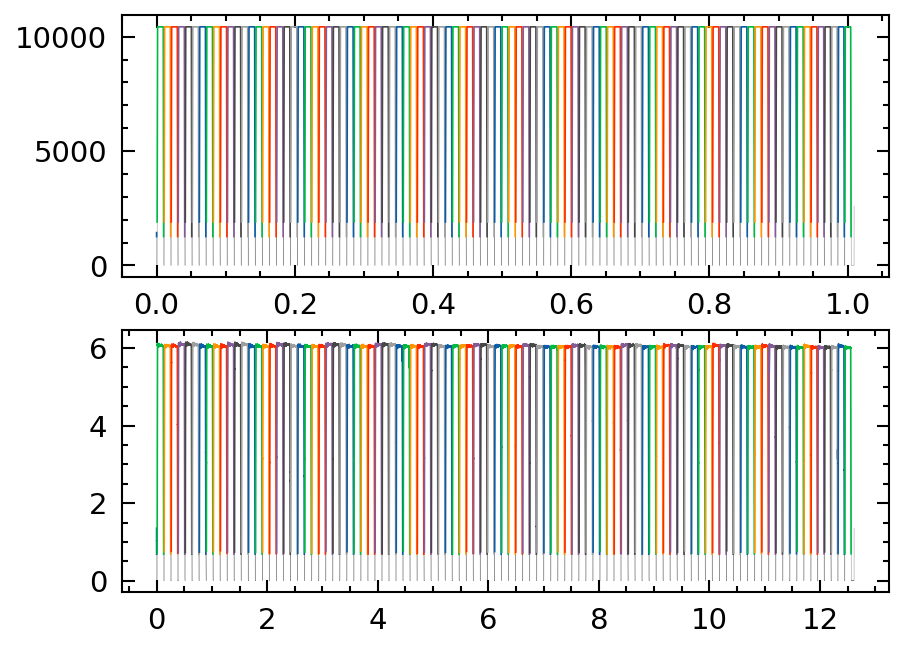

In [24]:
_t_lmq = np.linspace(0,len(lpbf.current_laserdiode)/lpbf.sampling_rate_lmq,len(lpbf.current_laserdiode))
_t_daq = np.linspace(0,len(lpbf.current_photodiode)/lpbf.sampling_rate_lmq,len(lpbf.current_photodiode))
fig, ax = plt.subplots(nrows=2)
ax[0].plot(_t_lmq, lpbf.current_laserpower,lw=0.1,c='k',alpha=0.5)
ax[1].plot(_t_daq, lpbf.current_photodiode,lw=0.1,c='k',alpha=0.5)
for i0,it in lpbf.line_indices_lmq:
    # ax[0].scatter(_t_lmq[i0:it], normalize_array(lpbf.current_laserdiode[i0:it]),s=0.01)
    ax[0].plot(_t_lmq[i0:it], (lpbf.current_laserpower[i0:it]),lw=0.4)

for i0,it in lpbf.line_indices_daq:
    ax[1].plot(_t_daq[i0:it], (lpbf.current_photodiode[i0:it]),lw=0.4)
plt.show()
    

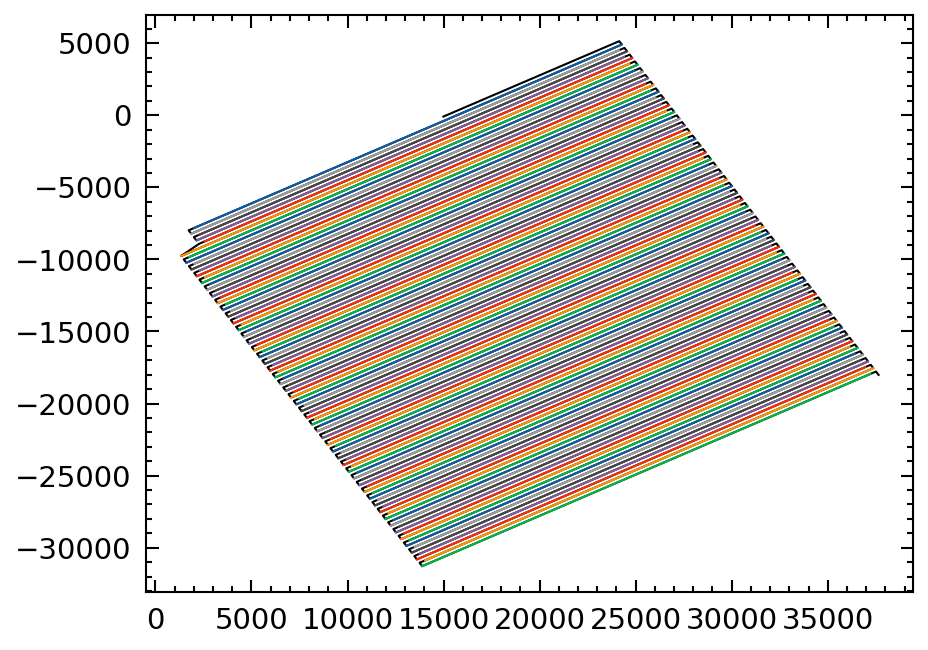

In [25]:
fig, ax = plt.subplots()
ax.plot(lpbf.current_x[:-1000],lpbf.current_y[:-1000],lw=0.5,c='k')
for i0,it in lpbf.line_indices_lmq[:-1]:
    ax.plot(lpbf.current_x[i0:it],lpbf.current_y[i0:it],lw=0.5)
plt.show()

In [37]:
from InterfaceDeclaration import LPBFInterface
class LPBFData(LPBFInterface):
    def __init__(self,context_info,defect_labels,in_process_data):
        self.context_info = context_info
        self.defect_labels = defect_labels
        self.in_process_data = in_process_data

lpbf_data = LPBFData(
context_info={
    "cube_position": lpbf.cube_position,
    "laser_power": lpbf.laser_power_setting,
    "start_coord": lpbf.start_coord,
    "end_coord":   lpbf.end_coord,
    "scanning_speed": lpbf.scanning_speed,
    "regime_info": lpbf.regime_info,
},
defect_labels=lpbf.defect_labels,
in_process_data={
    "microphone": lpbf.microphone,
    "ae": lpbf.ae,
    "photodiode": lpbf.photodiode,
    }
)
scanning_vector = lpbf_data._get_direction

In [43]:
import pickle
with open(os.path.join(os.path.dirname(daq_dir),'intermediate',f"lpbf_line_wise_data"), "wb") as fp:   
    pickle.dump(lpbf_data, fp)